In [1]:
import torch, torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd.variable import Variable

def torch_imshow(img):
    img = img[0]
    plt.imshow(img.numpy())
    plt.show()
    

class GANVisualizer:
    '''
    This class is a utility for visualizing
    generator samples using fixed latent vector to
    track the training of a GAN.
    '''
    def __init__(self):
        #self.z = torch.randn(16, 100).cuda()
        self.z = torch.randn(16, 100)
    
    def visualize(self, generator):
        with torch.no_grad():
            imgs = generator(self.z)
            fig, axes = plt.subplots(4, 4, figsize=(15, 15))
            for n in range(16):
                axis_row = n // 4
                axis_col = n % 4
                
                subplot = axes[axis_row, axis_col] 
                subplot.axis('off')
                # img = subplot.imshow(imgs[n].cpu().reshape(28, 28))
                img = subplot.imshow(imgs[n].reshape(28, 28))
                img.set_cmap('gray')
        plt.show()

visualizer = GANVisualizer()

In [2]:
#Create dataset and dataloader
BATCH_SIZE = 16

mnist = torchvision.datasets.MNIST('./', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset=mnist, batch_size=BATCH_SIZE, shuffle=True)

In [3]:
class FCNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = torch.nn.Sequential(
        torch.nn.Linear(input_dim, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, output_dim),
        torch.nn.Sigmoid()
        )
    def forward(self, x):
        x = self.layers(x)
        return x
        
        
generator     = FCNet(100, 256, 784)
discriminator = FCNet(784, 256, 1)


print('--Generator--')
dummy_input_g = torch.randn(16, 100)
dummy_output_g = generator(dummy_input_g)
print(generator)
print(f'Dummy input shape: {dummy_input_g.shape}')
print(f'Dummy output shape: {dummy_output_g.shape}')


print('--Discriminator--')
print(discriminator)
dummy_input_d = torch.randn(16, 784)
dummy_output_d = discriminator(dummy_input_d)
print(f'Dummy input shape: {dummy_input_d.shape}')
print(f'Dummy output shape: {dummy_output_d.shape}')



--Generator--
FCNet(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Dummy input shape: torch.Size([16, 100])
Dummy output shape: torch.Size([16, 784])
--Discriminator--
FCNet(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Dummy input shape: torch.Size([16, 784])
Dummy output shape: torch.Size([16, 1])


In [4]:
# Define an optimizer for both generator and discriminator
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)


In [5]:
## Define loss function for GAN suited for the networks you defined
loss = torch.nn.BCELoss()


In [6]:
# this website helps me a lot:
# https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

# Helper funcitons
def train_discriminator(optimizer, real_data, fake_data):
    """
    This function is for training of the Discriminator of a GAN Model.
    Discriminator's goal is to classify the real and fake data.
    For this reason, Discriminator takes both real and fake data
    to calculate its cost funciton. Discriminator output is 0 and 1
    for fake and real data respectively
    
    Parameters
    ----------
    optimizer : torch.nn optimizer object
    Control training process of a model
    
    real_data : TYPE
    Samples from the training data.
    
    fake_data : TYPE
    Output of the Generator.
    """
    # get size info to use later
    N = real_data.size(0)
    # reset gradients
    optimizer.zero_grad()
    
    # train using real_data : Calculate error and backpropagate
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, Variable(torch.ones(N, 1)) )
    error_real.backward()
    
    # train using fake data : Calculate error and backpropagate
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, Variable(torch.zeros(N, 1)) )
    error_fake.backward()
    
    # update only Discriminator's parameters
    optimizer.step()
    
def train_generator(optimizer, fake_data):
    """
    This function is for training of the Generator of a GAN Model.
    Generator's goal is to fool the Discriminator so Generator takes noisy
    input and produce fake data which looks like a realistic data.
    For this reason, Generator needs feedback from the Discriminator.
    Parameters
    ----------
    optimizer : torch.nn optimizer object
    Control training process of a model
    
    fake_data : TYPE
    Output of the Generator.
    """
    # get size info to use later
    N = fake_data.size(0)
    # reset gradients
    optimizer.zero_grad()
    # get feedback from Discriminator : Calculate error and backpropagate
    prediction = discriminator(fake_data)
    error = loss(prediction, Variable(torch.ones(N, 1)))
    error.backward()
    # update only Generator's parameters
    optimizer.step()

    
    
    
    

Epoch: 1


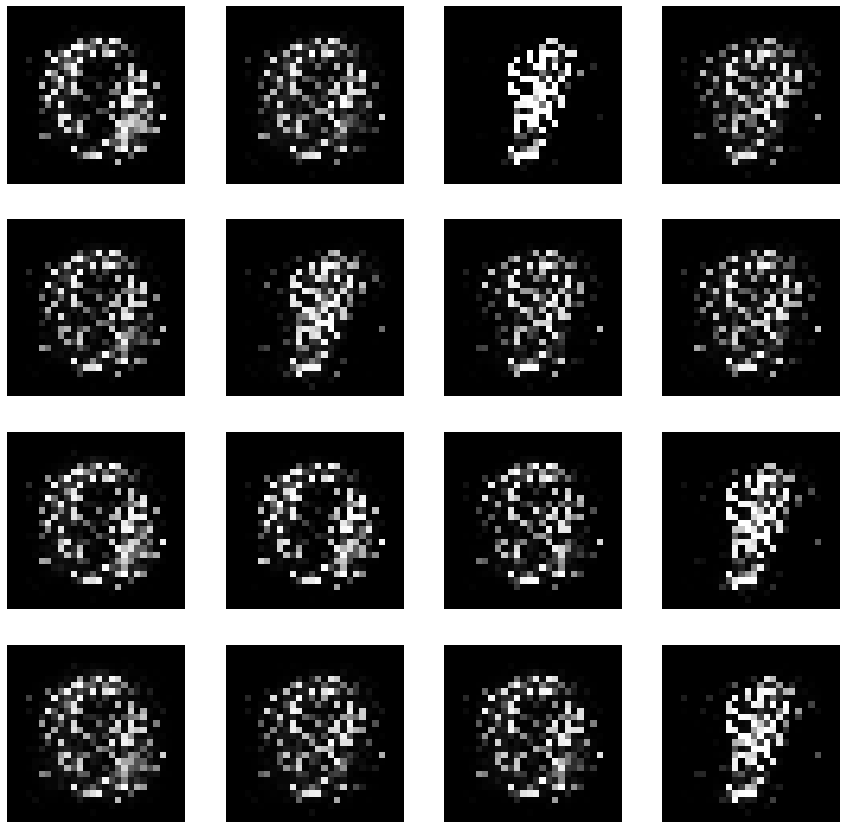

Epoch: 2


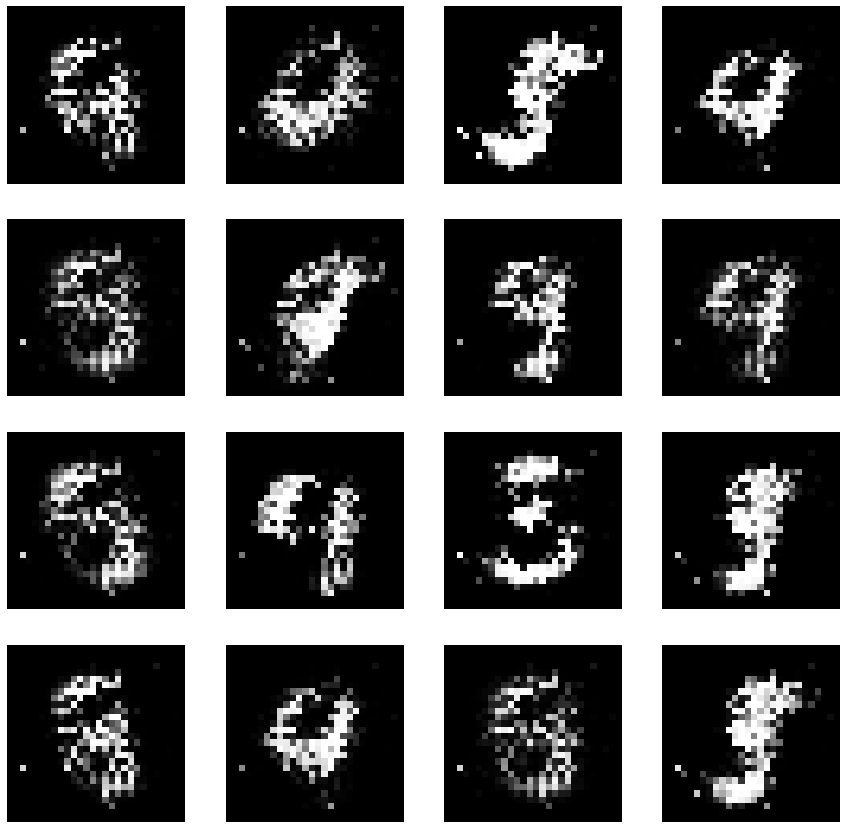

Epoch: 3


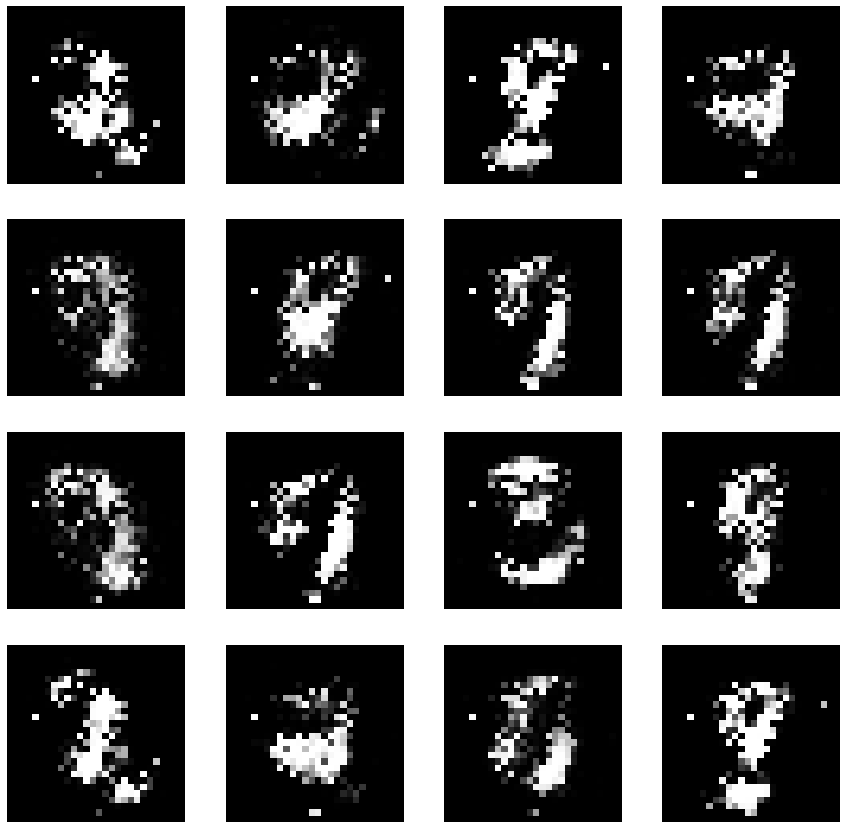

Epoch: 4


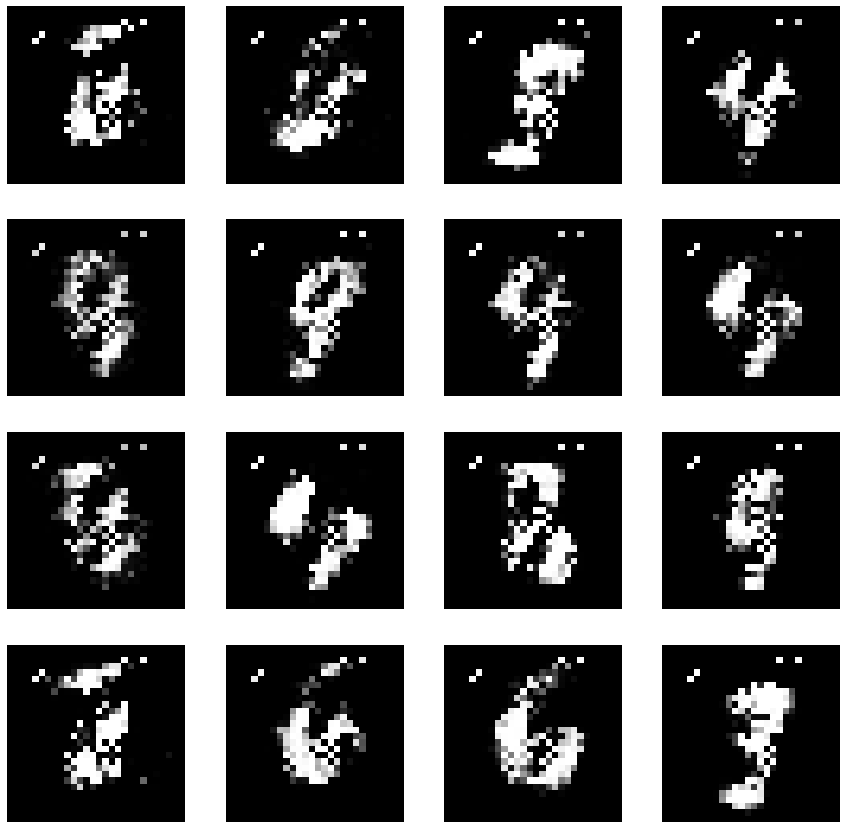

Epoch: 5


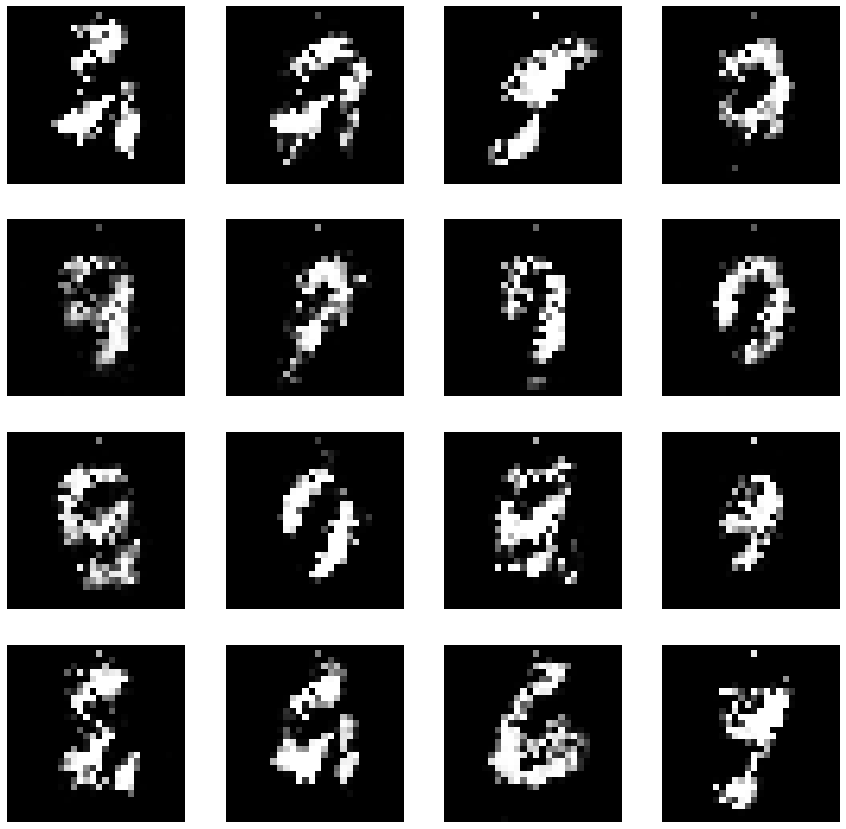

Epoch: 6


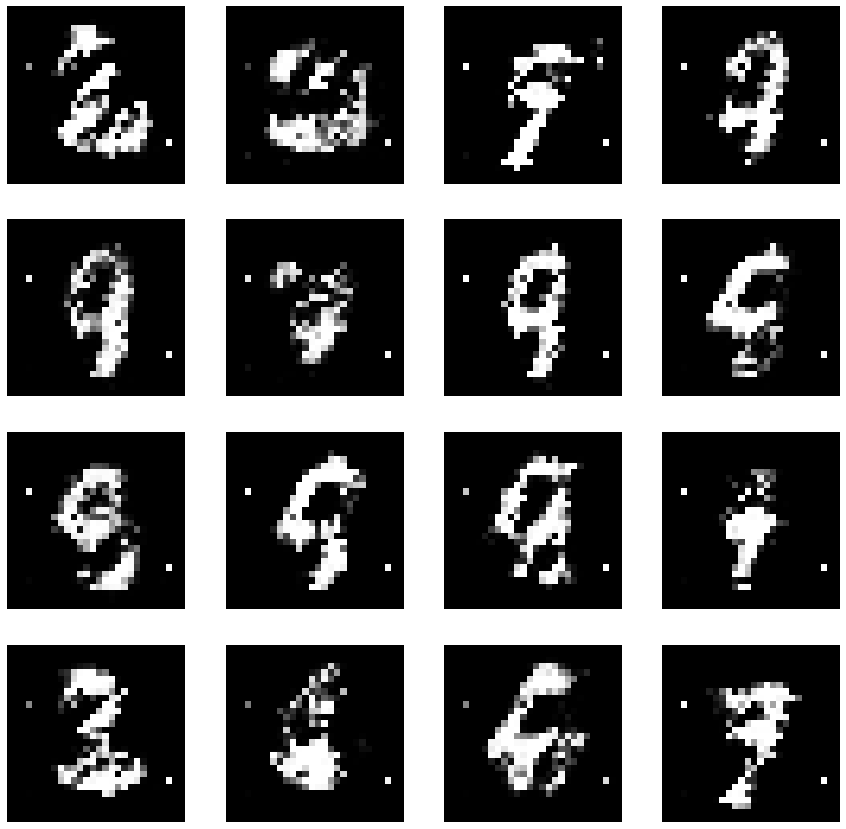

Epoch: 7


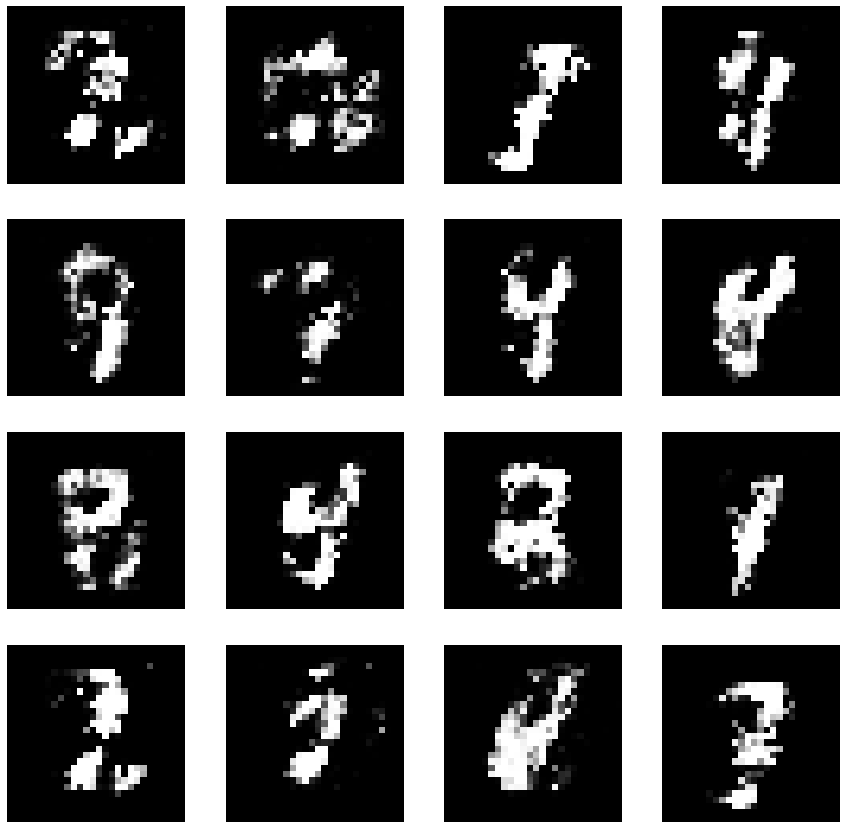

Epoch: 8


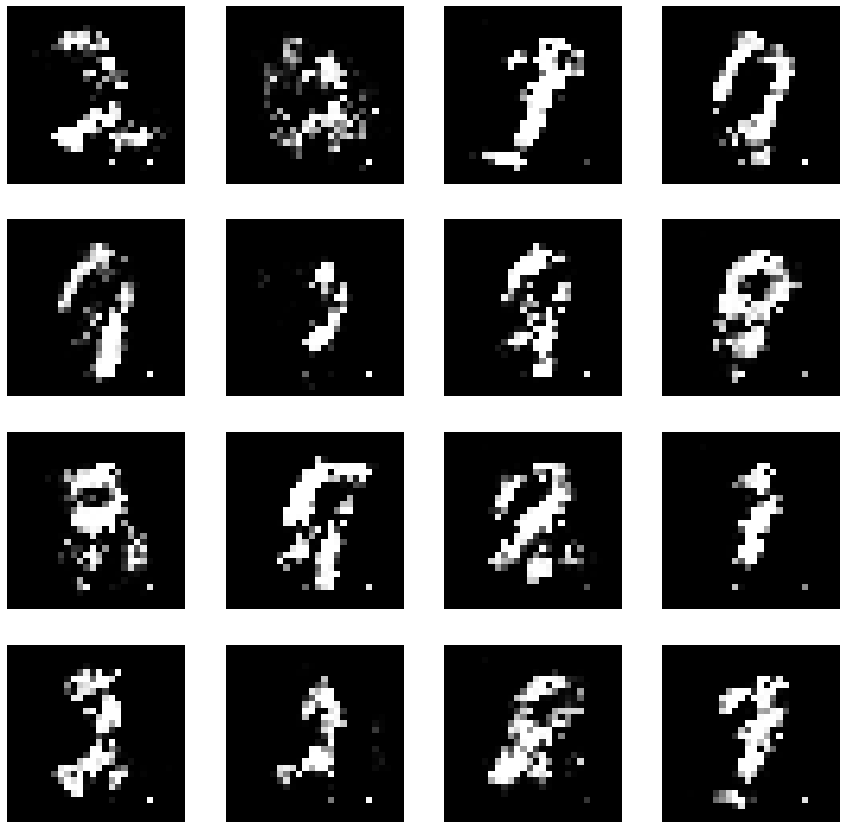

Epoch: 9


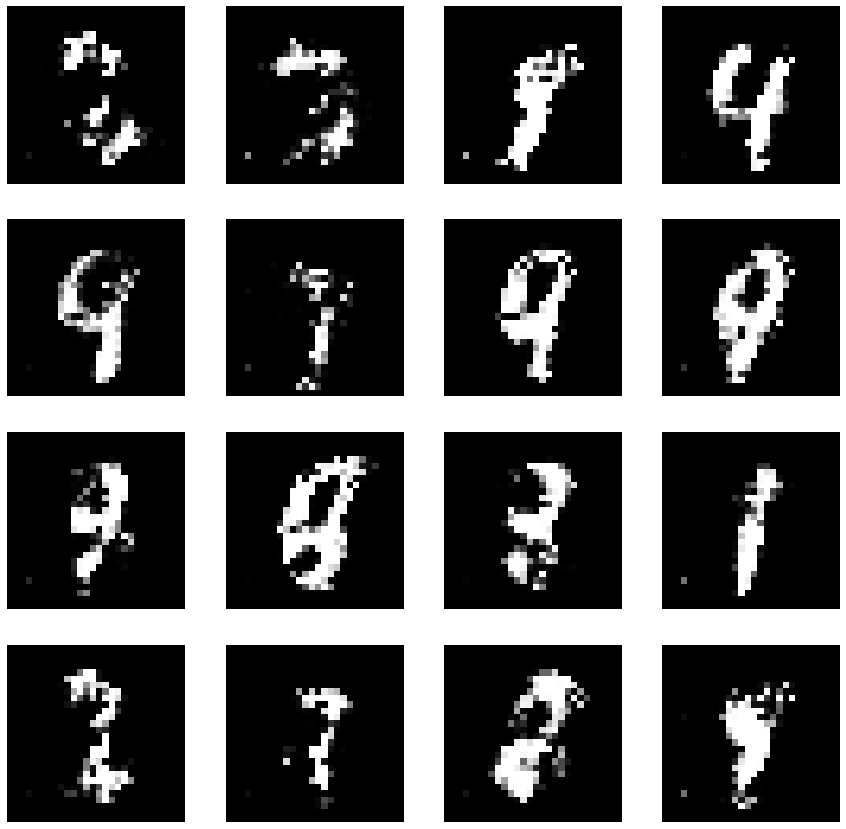

Epoch: 10


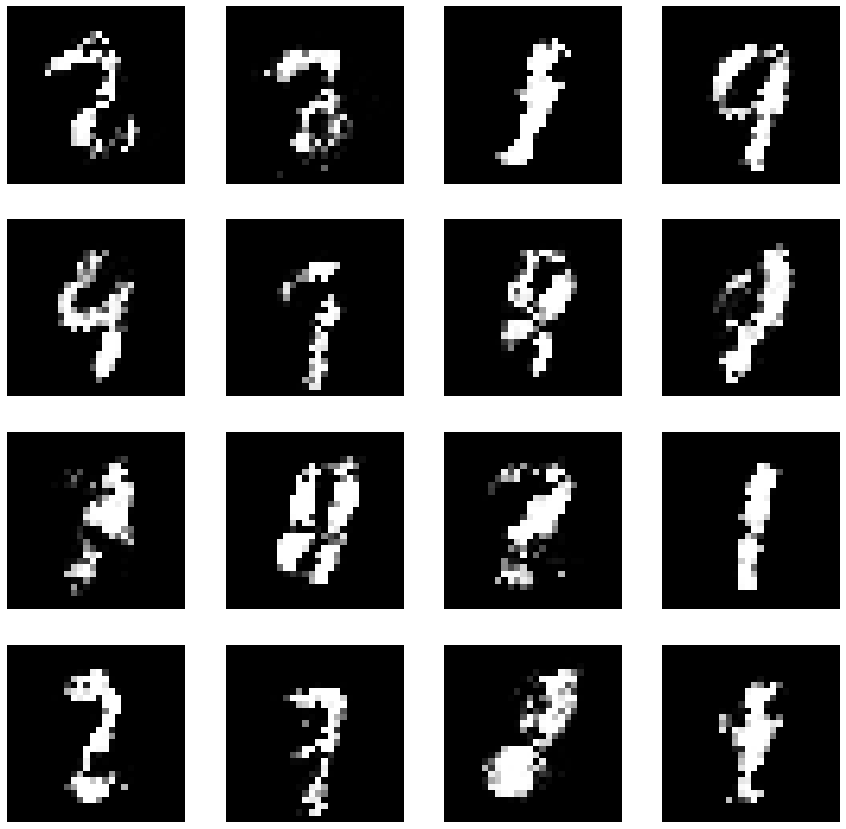

Epoch: 11


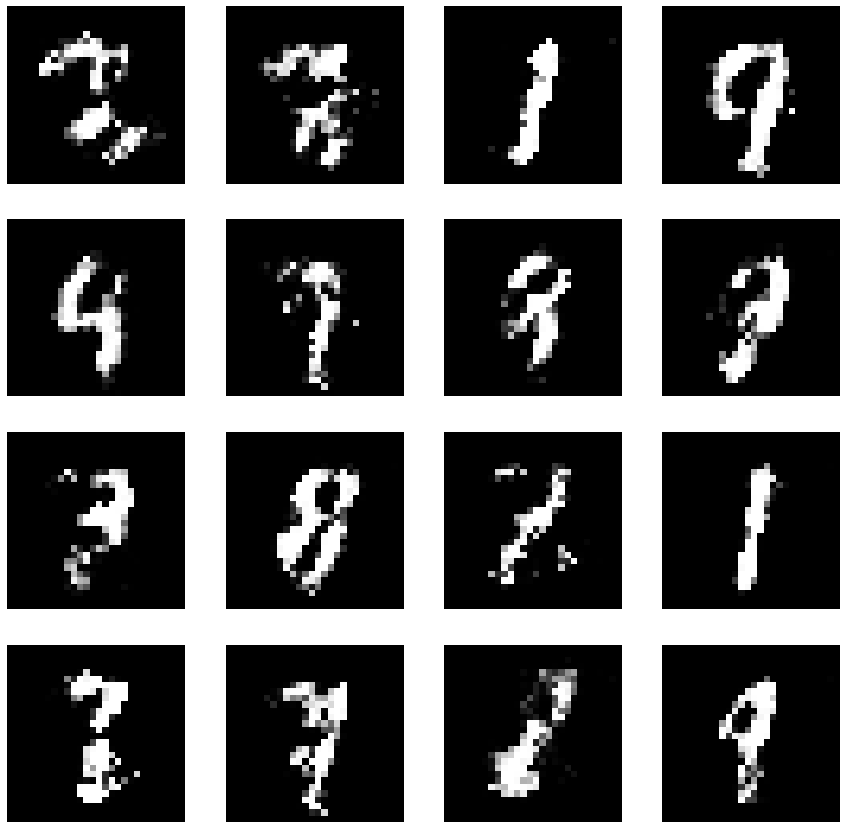

Epoch: 12


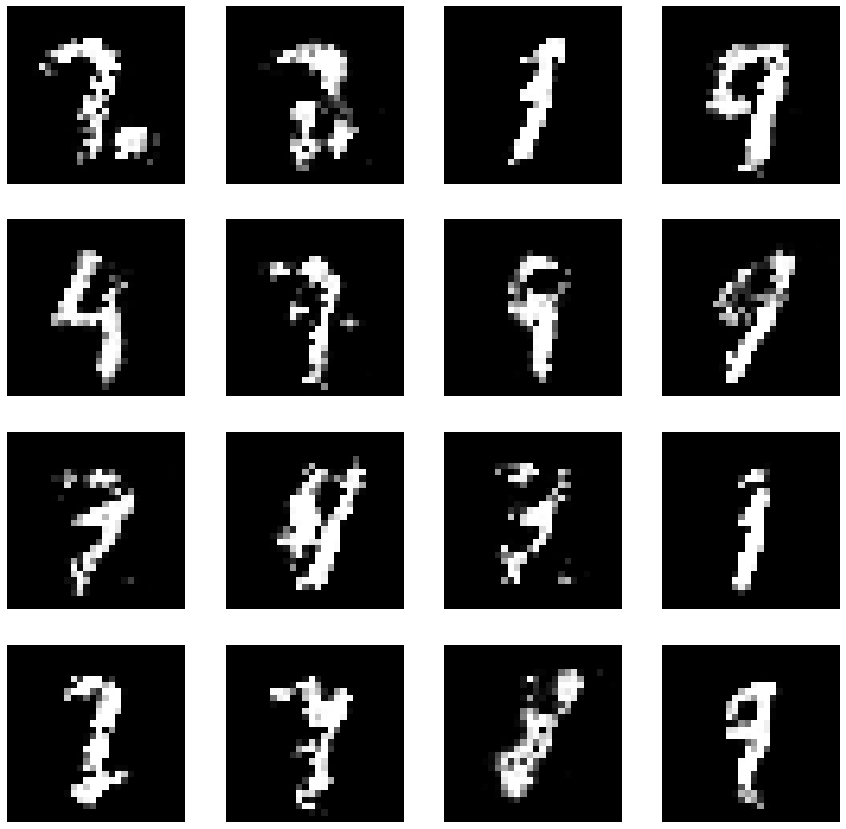

Epoch: 13


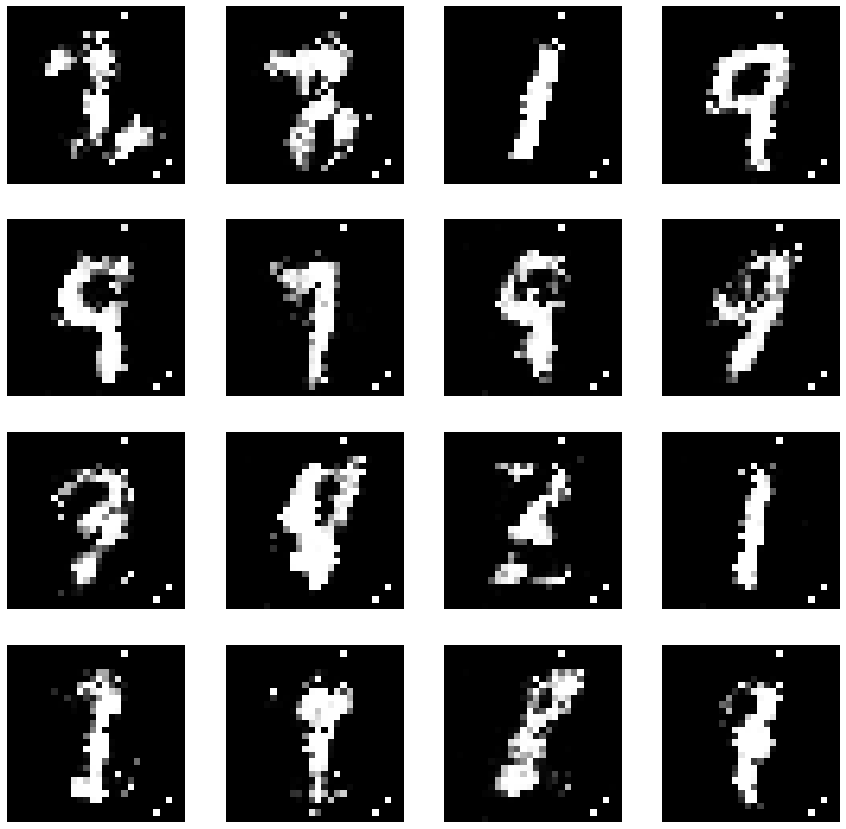

Epoch: 14


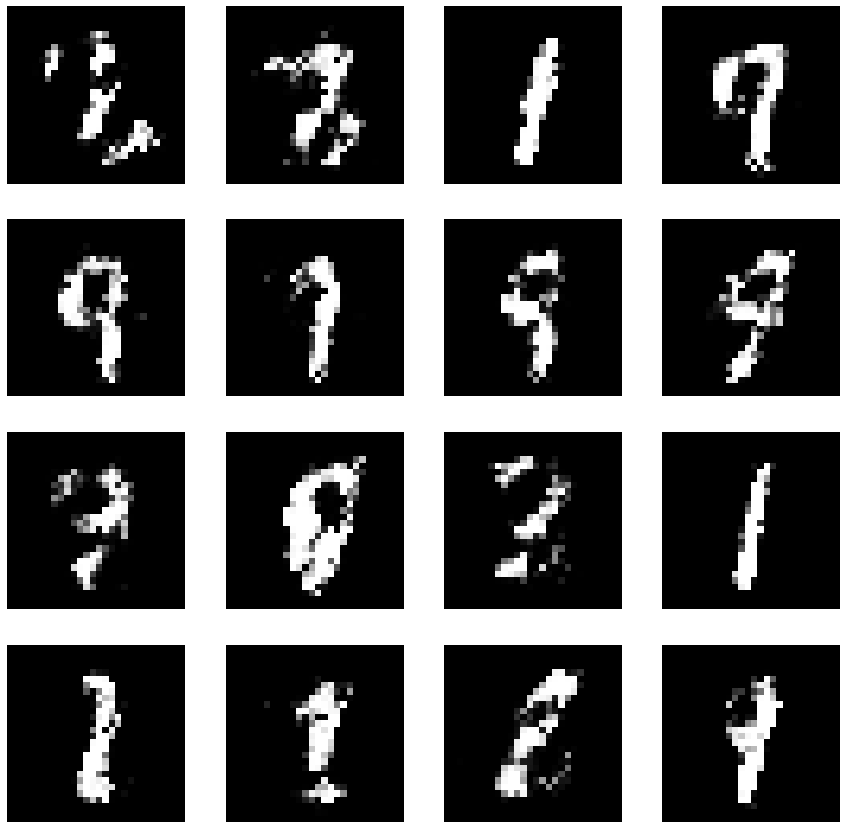

Epoch: 15


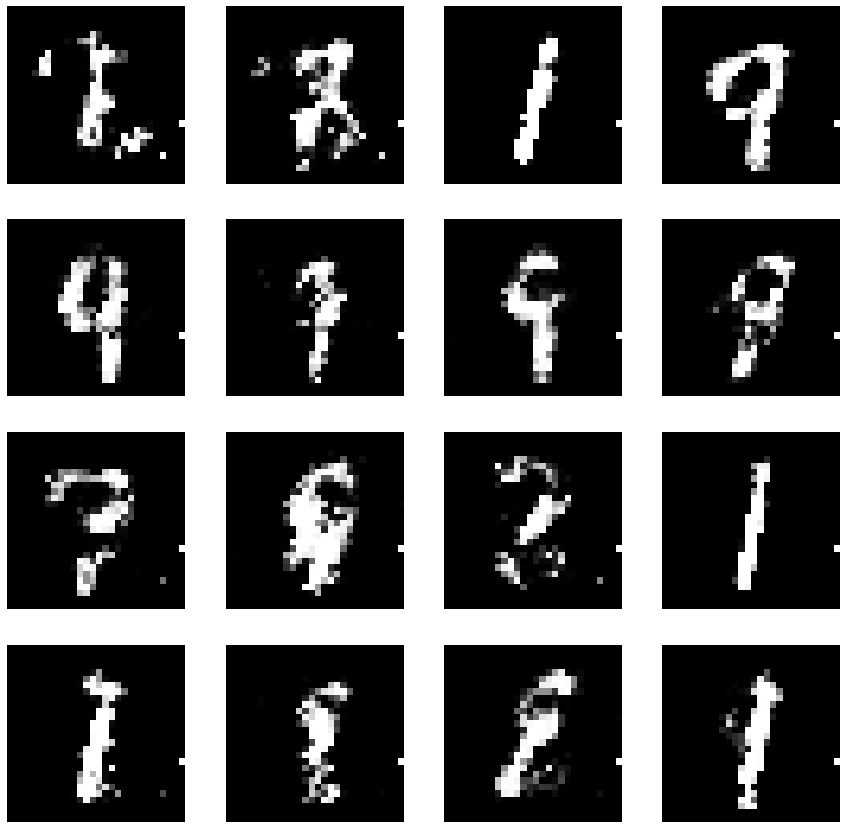

In [7]:
for epoch in range(15):
    print(f'Epoch: {epoch + 1}')
    
    for iteration, (real_imgs, labels) in enumerate(train_dataloader):
        # convert into vector form
        #real_imgs = real_imgs.reshape(-1, 784).cuda()
        real_imgs = real_imgs.reshape(-1, 784)
        #z = torch.randn(BATCH_SIZE, 100).cuda()
        z = torch.randn(BATCH_SIZE, 100)
        # get size info to use later
        
        size = real_imgs.size(0)
        # Generate fake data and detach
        # (so gradients are not calculated for generator)
        fake_data = generator(Variable(z)).detach()
        # Train D
        train_discriminator(d_optimizer, real_imgs, fake_data)
        # 2. Train Generator
        # Generate fake data
        fake_data = generator(Variable(z))
        # Train G
        train_generator(g_optimizer, fake_data)
        
    # Visualize generator samples after the epoch
    visualizer.visualize(generator)